In [1]:
#Le preprocesseur : Cette partie du code a pour objectif de charger les données et de les préparer pour les algorithmes
#de machine learning
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

pd.set_option("display.max_columns", 100)

DATA_PATH = Path.cwd() / "data" 

def load_data(DATA_PATH):
    features_df = pd.read_csv(
        DATA_PATH / "training_set_features.csv", 
        index_col="respondent_id"
    )
    labels_df = pd.read_csv(
        DATA_PATH / "training_set_labels.csv", 
        index_col="respondent_id"
    )
    return features_df, labels_df


def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

def performance_analysis(y_preds, y_eval):
    fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

    plot_roc(
        y_eval['h1n1_vaccine'], 
        y_preds['h1n1_vaccine'], 
        'h1n1_vaccine',
        ax=ax[0]
    )
    plot_roc(
        y_eval['seasonal_vaccine'], 
        y_preds['seasonal_vaccine'], 
        'seasonal_vaccine',
        ax=ax[1]
    )
    fig.tight_layout()
    return

def load_test_data(DATA_PATH):
    test_features = pd.read_csv(DATA_PATH/"test_set_features.csv", index_col = "respondent_id")
    return test_features

def save_test_data(test_features, model, name_model):
    predictions = model.predict_proba(test_features)
    y_preds = pd.DataFrame(
           {
               "h1n1_vaccine": predictions[0][:, 1],
               "seasonal_vaccine": predictions[1][:, 1],
           }, index = test_features.index)
    s = 'predictions_' + name_model + '.csv'
    y_preds.to_csv(DATA_PATH/s)
    return y_preds

features_df, label_df = load_data(DATA_PATH)
print(features_df.columns)
X_train, X_eval, y_train, y_eval = train_test_split(features_df, label_df, test_size = 0.2, random_state = 42)
y_train_h1n1 = y_train["h1n1_vaccine"]
y_train_sf = y_train["seasonal_vaccine"]
y_eval_h1n1 = y_eval["h1n1_vaccine"]
y_eval_sf = y_eval["seasonal_vaccine"]

num_pipeline = Pipeline([('std_scaler', StandardScaler()),('imputer', SimpleImputer(strategy = "mean"))])
cat_pipeline = Pipeline([('Encoder',OneHotEncoder())])
num_attribs = features_df.columns[features_df.dtypes != "object"].values
cat_attribs = features_df.columns[features_df.dtypes == "object"].values

preprocessor = ColumnTransformer([("num", num_pipeline, num_attribs),
                                  ("cat", cat_pipeline, cat_attribs)])
X_train_prepared = preprocessor.fit_transform(X_train)

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')


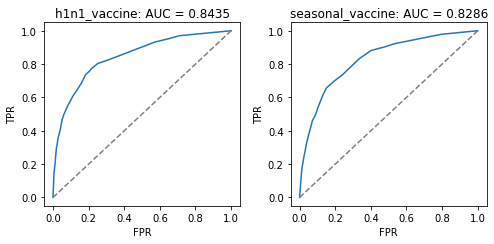

In [2]:
#Decision Tree 
#Cette partie du code entraîne un arbre décisionel et évalue sa performance

from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
estimators = MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth = 5))

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

full_pipeline.fit(X_train, y_train)

preds = full_pipeline.predict_proba(X_eval)
y_preds = pd.DataFrame(
       {
           "h1n1_vaccine": preds[0][:, 1],
           "seasonal_vaccine": preds[1][:, 1],
       },
       index = y_eval.index
   )
performance_analysis(y_preds, y_eval)

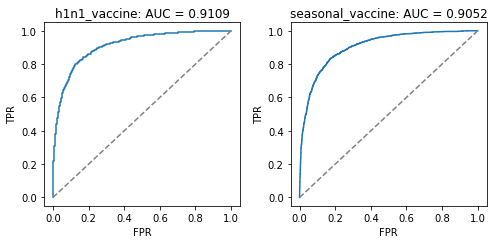

In [3]:
#Gradient Boosting
#Cette partie du code entraîne l'algorithme du gradient boosting et évalue sa performance

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

gb_clf = MultiOutputClassifier(HistGradientBoostingClassifier(scoring="roc_auc",
                                                               max_iter=110,
                                                               l2_regularization=110,
                                                               max_leaf_nodes=115,
                                                               learning_rate=0.12,
                                                              min_samples_leaf=1))

preprocessor = ColumnTransformer([("num", num_pipeline, num_attribs),
                                  ("cat", cat_pipeline, cat_attribs)])

full_pipeline = Pipeline([("preprocessor", preprocessor), ("estimator_final", gb_clf)])

full_pipeline.fit(features_df, label_df)

preds = full_pipeline.predict_proba(X_eval)
y_preds = pd.DataFrame(
       {
           "h1n1_vaccine": preds[0][:, 1],
           "seasonal_vaccine": preds[1][:, 1],
       },
       index = y_eval.index
   )
performance_analysis(y_preds, y_eval)

In [19]:
(0.9065 + 0.8955)/2

0.901

In [20]:
#Ce code permet d'optimiser les paramètres de l'algorithme du gradient boosting en choisissant la meilleure 
#combinaison possible parmis une grille de paramètres possibles.
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
parameters = {"estimator__max_iter":[90, 110],
                           "estimator__learning_rate":[0.12], 
              "estimator__max_leaf_nodes":[115, 120, 130],
             "estimator__l2_regularization":[110, 150,175, 200]}


gs_gb = GridSearchCV(estimator = MultiOutputClassifier(HistGradientBoostingClassifier()), param_grid = parameters)
gs_gb.fit(X_train_prepared, y_train)
gs_gb.best_params_

{'estimator__l2_regularization': 175,
 'estimator__learning_rate': 0.12,
 'estimator__max_iter': 110,
 'estimator__max_leaf_nodes': 115}

In [ ]:
#Réseau de neuronnes
#Ce code entraîne un réseau de neuronnes et évalue sa performance

import tensorflow as tf
from tensorflow import keras
y_train_ann = y_train.copy()
y_train_ann["no_h1n1_vaccine"] = 1 - y_train_ann["h1n1_vaccine"]
y_train_ann["no_seasonal_vaccine"] = 1 - y_train_ann["seasonal_vaccine"]
X_train_ann, X_valid , y_train_ann, y_valid = train_test_split(X_train_prepared,y_train_ann, random_state = 42, test_size = 0.1)
model = keras.models.Sequential()
model.add(keras.layers.Dense(112, activation = "relu"))
model.add(keras.layers.Dense(95, activation = "relu"))
#model.add(keras.layers.Dense(30, activation = "relu"))
model.add(keras.layers.Dense(4, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["AUC"])
history = model.fit(X_train_ann, y_train_ann, epochs = 30, validation_data = (X_valid, y_valid))
X_eval_ann = preprocessor.transform(X_eval)
preds = model.predict(X_eval_ann)
y_preds = pd.DataFrame(
       {
           "h1n1_vaccine": preds[:,0],
           "seasonal_vaccine": preds[:,1],
       },
       index = y_eval.index
   )
performance_analysis(y_preds, y_eval)

In [ ]:
#Cette partie du code recherche la meilleure combinaison de paramètres possibles parmi un ensemble de paramètres possible pour 
#
import scikeras
from scikeras.wrappers import KerasClassifier

def build_model(n_hidden = 1, n_neurons  = 30, learning_rate = 3e-3, input_shape = [112]):
    model = keras.models.Sequential()
    options = {"input_shape":input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation = "relu", **options))
        options = {}
    model.add(keras.layers.Dense(4, activation = "sigmoid", **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["AUC"])
    return model
keras_clf = keras.wrappers.scikit_learn.KerasRegressor(build_model, learning_rate = 0.007, n_hidden = 1, n_neurons = 95)
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {"n_hidden":[1], "n_neurons":np.arange(1, 50), "learning_rate":[0.03, 0.035, 0.4, 0.45, 0.5, 0.55, 0.6]}
#param_distribs2 = {"model":<function __main__.build_model(n_hidden=1, n_neurons=30, learning_rate=0.003, input_shape=[112])>}
rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter = 10, cv = 3)
rnd_search_cv.fit(X_train_ann, y_train_ann, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=10)], epochs = 3)

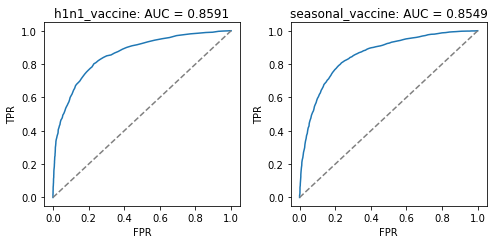

In [7]:
#Random forest
#Ce code entraîne une random forest et évalue sa performance
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
estimators = RandomForestClassifier(n_estimators = 128)

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

full_pipeline.fit(X_train, y_train)


preds = full_pipeline.predict_proba(X_eval)
y_preds = pd.DataFrame(
       {
           "h1n1_vaccine": preds[0][:, 1],
           "seasonal_vaccine": preds[1][:, 1],
       },
       index = y_eval.index
   )
performance_analysis(y_preds, y_eval)

c:\users\yohan\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\users\yohan\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

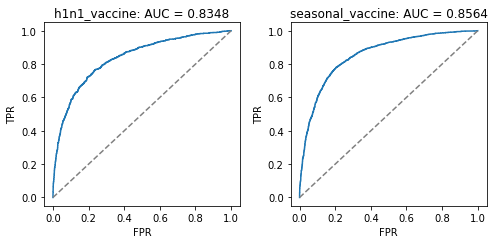

In [9]:
from sklearn.linear_model import LogisticRegression
estimators = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l2", C=1)
)

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])


# Train model
full_pipeline.fit(X_train, y_train)


preds = full_pipeline.predict_proba(X_eval)
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
performance_analysis(y_preds, y_eval)